In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
from models.Resnet50_multiply_TL_2 import resnet50_multiply
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
# 先把根目錄用到food11
import os
# load dataset
dataset_dir = './food11'
# create new dir
try:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    for i in range(11):
        os.mkdir(f'train/{i:02d}')
        os.mkdir(f'valid/{i:02d}')
except:
    pass

# create new file structure for dataset
for index, sub_dir in enumerate(['training', 'validation', 'test']):
    target_dir = os.path.join(dataset_dir, sub_dir)
    img_list = os.listdir(target_dir)
    for img_name in img_list:
        category, *r = img_name.split('_')
        img_path = os.path.join(target_dir, img_name)
        string = ""
        for j in range(4):
            if category[j]!='0':
                string += category[j]
        category = int(string)
        if index == 2:
            new_fn = f'test/{img_name}'
        else:
            new_fn = f'{sub_dir[:5]}/{category:02d}/{img_name}'
        os.rename(img_path, new_fn)

In [3]:
# Dataset preprocessing
batch_size = 25
data_transform = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True) #image augmentation
train_data = data_transform.flow_from_directory(
        'train',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='sparse')
valid_data = data_transform.flow_from_directory(
        'valid',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='sparse')
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    image_size=(299,299),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
)
test_data = test_set.map(lambda x: (tf.divide(x, 255)))

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 files belonging to 1 classes.


In [4]:
pre_trained_model = InceptionV3(input_shape=(299, 299, 3), include_top = False, weights = 'imagenet')
last_layer = pre_trained_model.get_layer('mixed7') #引入mixed8以前InceptionV3的layer和權重 
last_output = last_layer.output
outputs = resnet50_multiply(last_output)
model = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=outputs, name='Resnet50_multiply')
model.summary()
plot_model(model, to_file='models\ResNet50_multiply_truncated.png', show_shapes=True)

Model: "Resnet50_multiply"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________

In [5]:
##調整學習率，採用學習率隨epoch數上升呈遞減的狀態，避免一開始學習過慢，之後overshooting的情形
model_dir=r'.\models\Resnet50_multiply_TL_2'
os.makedirs(model_dir)
log_dir = os.path.join('exam','model_Resnet50_multiply_TL_2')
model_cbk=keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp=keras.callbacks.ModelCheckpoint(model_dir + '/Best_exam_model.h5', monitor='val_sparse_categorical_accuracy',save_best_only=True,mode='max')
model.compile(keras.optimizers.Adam(),loss=keras.losses.SparseCategoricalCrossentropy(),metrics=[keras.metrics.SparseCategoricalAccuracy()])
history_1=model.fit(train_data,epochs=50,validation_data=valid_data,callbacks=[model_cbk,model_mckp])

Epoch 1/50
395/395 [==============================] - 250s 598ms/step - loss: 7.0272 - sparse_categorical_accuracy: 0.2215 - val_loss: 6.4113 - val_sparse_categorical_accuracy: 0.1050
Epoch 2/50
395/395 [==============================] - 232s 587ms/step - loss: 3.6578 - sparse_categorical_accuracy: 0.3065 - val_loss: 21.9107 - val_sparse_categorical_accuracy: 0.2586
Epoch 3/50
395/395 [==============================] - 233s 589ms/step - loss: 2.5679 - sparse_categorical_accuracy: 0.3685 - val_loss: 19.8547 - val_sparse_categorical_accuracy: 0.2335
Epoch 4/50
395/395 [==============================] - 231s 585ms/step - loss: 2.0759 - sparse_categorical_accuracy: 0.4199 - val_loss: 5.2257 - val_sparse_categorical_accuracy: 0.3341
Epoch 5/50
395/395 [==============================] - 234s 592ms/step - loss: 1.7524 - sparse_categorical_accuracy: 0.4882 - val_loss: 1.7950 - val_sparse_categorical_accuracy: 0.4816
Epoch 6/50
395/395 [==============================] - 234s 593ms/step - loss: 

395/395 [==============================] - 234s 592ms/step - loss: 0.3445 - sparse_categorical_accuracy: 0.9171 - val_loss: 1.0135 - val_sparse_categorical_accuracy: 0.7656
Epoch 46/50
395/395 [==============================] - 233s 589ms/step - loss: 0.3074 - sparse_categorical_accuracy: 0.9273 - val_loss: 0.8491 - val_sparse_categorical_accuracy: 0.7971
Epoch 47/50
395/395 [==============================] - 231s 584ms/step - loss: 0.3102 - sparse_categorical_accuracy: 0.9270 - val_loss: 0.8788 - val_sparse_categorical_accuracy: 0.7741
Epoch 48/50
395/395 [==============================] - 230s 583ms/step - loss: 0.2985 - sparse_categorical_accuracy: 0.9292 - val_loss: 1.2750 - val_sparse_categorical_accuracy: 0.7117
Epoch 49/50
395/395 [==============================] - 232s 586ms/step - loss: 0.3057 - sparse_categorical_accuracy: 0.9302 - val_loss: 0.8507 - val_sparse_categorical_accuracy: 0.7904
Epoch 50/50
395/395 [==============================] - 231s 585ms/step - loss: 0.2935 -

In [6]:
model.load_weights('models\Resnet50_multiply_TL_2\Best_exam_model.h5')
answer = model.predict(test_data)
df = pd.DataFrame()
df["Id"] = ["0"*(4-len(str(i)))+str(i) for i in range(1,np.shape(answer)[0]+1)]
def get_class(i):
    top_1_index = np.argsort(answer[i])[10]
    return top_1_index 
df["Category"] = [get_class(i) for i in range(0,np.shape(answer)[0])]
df.to_csv("test_result\submission_TL_2.csv",index = False)

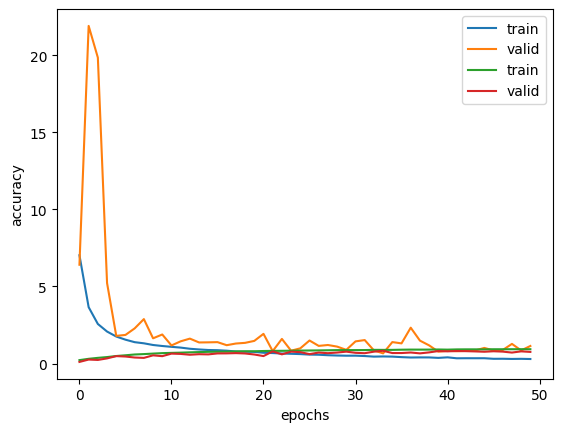

In [7]:
plt.plot(history_1.history['loss'], label='train')
plt.plot(history_1.history['val_loss'], label='valid')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

plt.plot(history_1.history['sparse_categorical_accuracy'], label='train')
plt.plot(history_1.history['val_sparse_categorical_accuracy'], label='valid')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(loc='upper right')

雖然上一次的Resnet50_multiply with transfer learning training model準確率達到83%，但是accuracy在epoch 40之後出現震盪的情況，我懷疑是出現輕微過擬合的情況或是keras.optimizers的learning rate參數設得太死，讓accuracy在靠近局域最大值時無法順利逼近。因此我將optimizer改成課本推薦的Adams。
此外，細看InceptinV3的結構，在mixed7之後會執行一套maxpooling2D，再concatenate成mixed8，而InceptionV3和我們想要訓練的食物辨識模型屬於小資料、低相似度的情況，所以所有高階辨識的layers都可以拿掉，只需要InceptionV3中的低階辨識權重。因此，我決定只保留mixed7(含)以前的layers，丟棄從mixed8開始的高階辨識layers。
以下是這次模型的結果，準確率為86%。不太確定為甚麼一開始的loss會大幅度震盪，或許跟我把optimizer從SGD改成Adam有關。
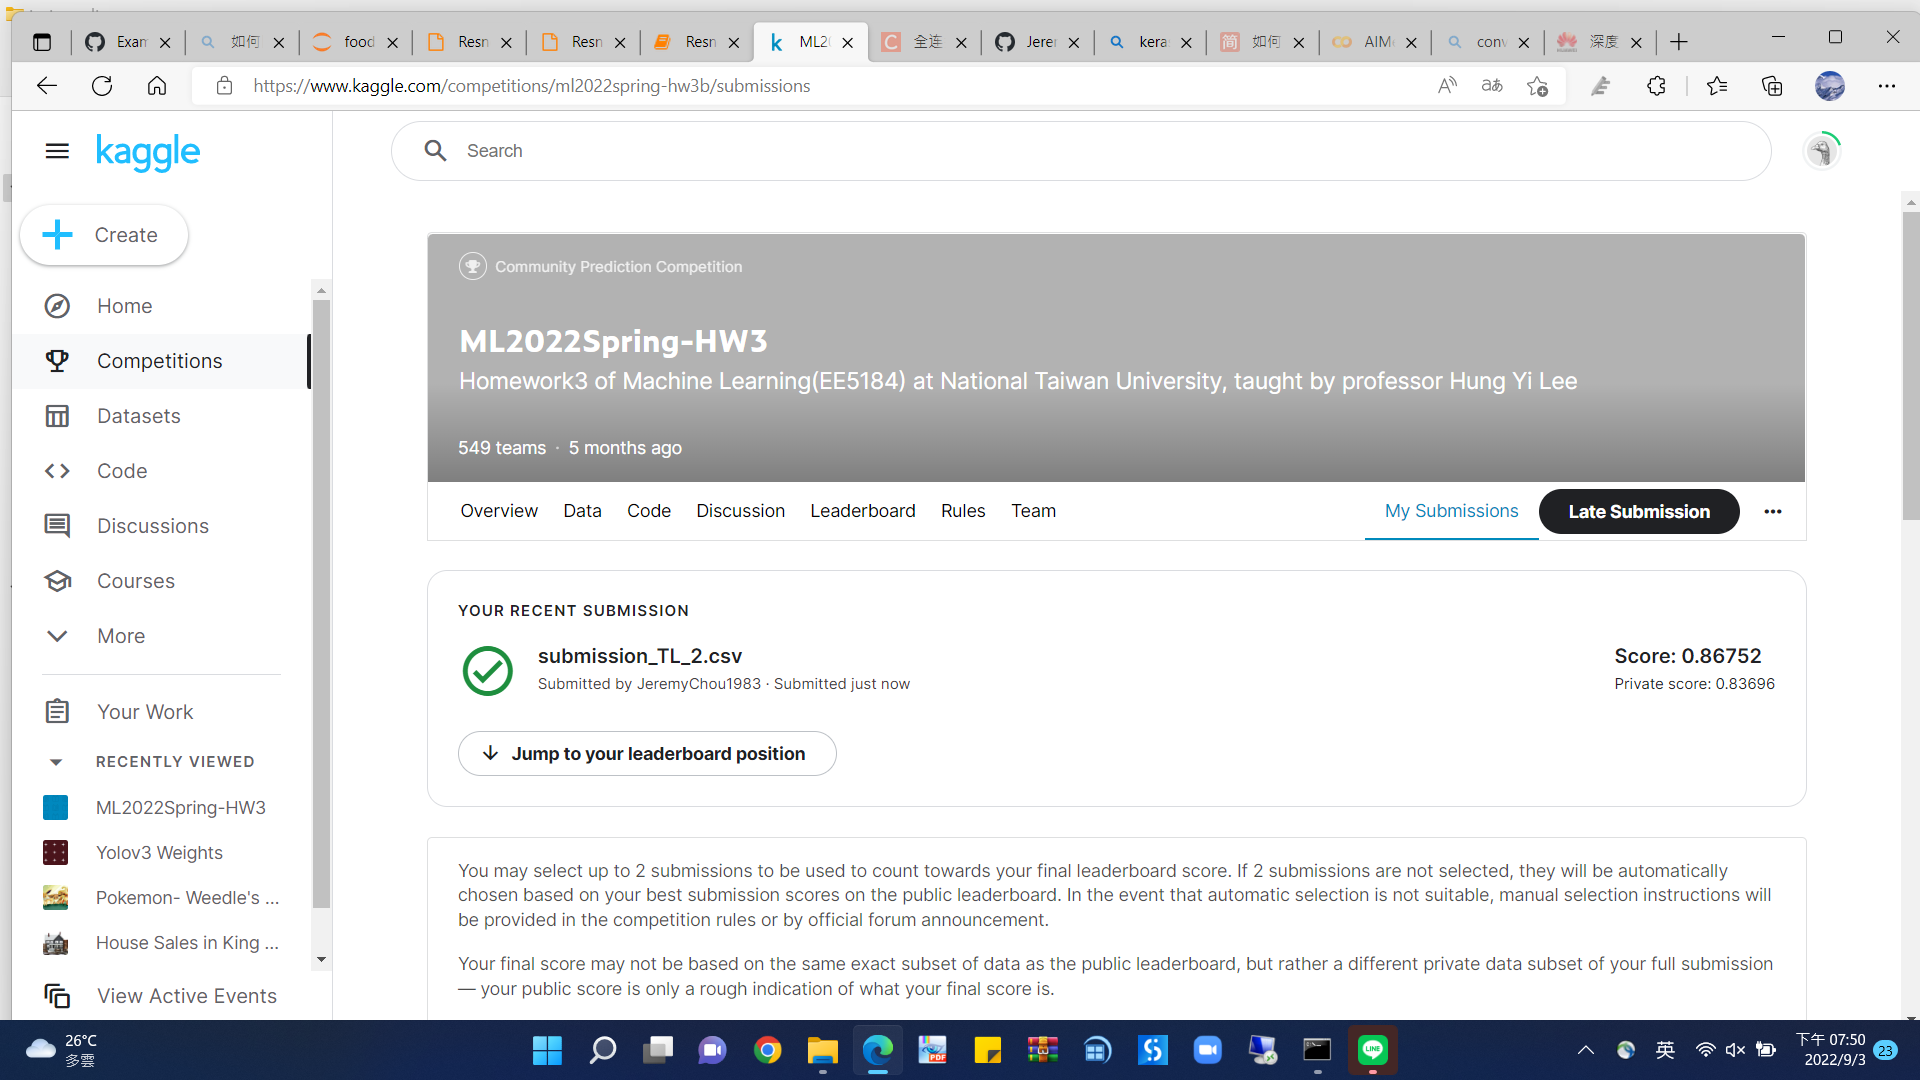